# March Madness Experiment Refactored


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from pathlib import Path
home = str(Path.home())
import sys
sys.path.insert(0,"%s/sensitivity_study/src"%home)
from experiment import read_raw_pairwise, construct_support_matrix, get_features_from_support, get_target_stability, eval_models
from sensitivity_tests import *
import utilities

In [3]:
years = ["2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009",
             "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018"]

config = {
    "col_mapping": {
        "team1_name":"team1_name",
        "team1_score":"points1",
        "team2_name":"team2_name",
        "team2_score":"points2",
        "team1_select": "team1_madness",
        "team2_select": "team2_madness",
        "date":"date"
    },
    "rankingMethod": MasseyRankingAlgorithm(),
    "correlationMethod":utilities.kendall_tau,
    "pair": (.75, 1.0),
    "n_restarts": 5,
    "direct_thres": 2,
    "spread_thres": 2,
    "weight_indirect": 0.5,
    "raw_filepaths": ["{}/sensitivity_study/data/MarchMadnessDataFrames/march_madness_{}.csv".format(home,yr) for yr in years],
    "model_list": [{"model":DummyRegressor(), "param_grid": {}},
                   {"model":LinearRegression(), "param_grid": {'fit_intercept': [True, False]}}]
}

In [4]:
games = {fp: read_raw_pairwise(fp, config["col_mapping"]) for fp in tqdm(config["raw_filepaths"])}

100%|██████████| 17/17 [00:00<00:00, 38.47it/s]


In [5]:
target_list = []
support_matricies = {}
feature_df_list = []
# For each raw file (equivalent to a season / tournament / single scenario)
# get feature vector and target scalar
for fp in tqdm(games.keys()):
    support_matricies[fp] = {}
    # For both fractions in pair, construct the support matrices
    for frac in config["pair"]:
        support_matricies[fp][frac] = construct_support_matrix(games[fp],
                                                               frac,
                                                               direct_thres=config["direct_thres"],
                                                               spread_thres=config["spread_thres"],
                                                               weight_indirect=config["weight_indirect"])
    # Now from the less-informed support, get features
    feature_df_list.append(get_features_from_support(support_matricies[fp][config["pair"][0]], config["n_restarts"]))
    feature_df_list[-1].name = fp

    # From both less-informed and more informed supports, get target (rank correlations)
    target_list.append(get_target_stability(support_matricies[fp][config["pair"][0]],
                                            support_matricies[fp][config["pair"][1]],
                                            config["rankingMethod"],
                                            config["correlationMethod"]))
# good spot for a checkpoint: support_matricies
features = pd.DataFrame(feature_df_list)
targets = pd.Series(target_list,index=features.index)
# good spot for a checkpoint: features, targets

  0%|          | 0/17 [00:00<?, ?it/s]

Academic license - for non-commercial use only


100%|██████████| 17/17 [06:39<00:00, 23.50s/it]


In [6]:
results_dict = eval_models(features, targets, config["model_list"])

100%|██████████| 8190/8190 [12:18<00:00, 11.09it/s]


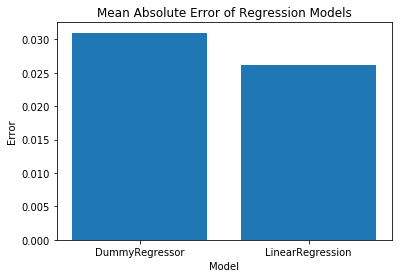

In [9]:
x = results_dict.keys()
maes = [results_dict[model]["MAE"] for model in x]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, maes)
plt.xlabel("Model")
plt.ylabel("Error")
plt.title("Mean Absolute Error of Regression Models")

plt.xticks(x_pos, x)

plt.show()